In [1]:
%matplotlib inline
import sys
sys.path.append("../")

from extract import DogExtractor
from sklearn.pipeline import Pipeline
from transform import (Normalization, RandomFlip, 
                       RandomRescaleAndCrop, RandomRotation,
                       RandomColorShift)
from load import DogDataGenerator
from utils import plot_images

import numpy as np

Using TensorFlow backend.


### Overview 

    DeepAI에서 사용하는 코드이면서, DeepAI의 강의용 컨텐츠에도 들어갈 수 있는 형태의 코드로 구현하였습니다. 사용할 때 보다 직관적으로 이용할 수 있도록 고려하였습니다.
    
모듈은 크게 3 가지로
   - extract.py : Dog Dataset에서 Data를 읽어옴
   - transform.py : Image를 전처리 혹은 Augment함
   - load.py : Keras .fit_generator에 적용할 수 있는 형태로 구현된 DataGenerator
   
입니다. 각 단계로 어떤식으로 이용가능하며, 데이터에 적용되는지 간단하게 살펴보는 예제 코드입니다.

## 1. extract.py

extract.py에서 핵심 클래스는 바로 `DogExtractor`입니다. Pandas Style의 Indexing을 지원합니다.

In [2]:
data_dir = "../data/" # 데이터셋이 저장된 위치, data_dir에 아래에 datainfo.txt가 없는 경우 데이터를 download하기 시작합니다.
dex = DogExtractor("../data/",keep_aspect_ratio=True)

/Users/ksj/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


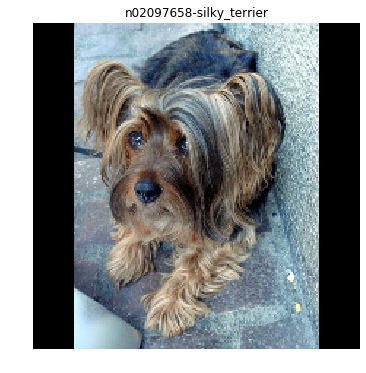

In [3]:
# indexing 하는 방법으로는 아래와 같이 single도 가능하고
image, label = dex[16]
plot_images(image, label)

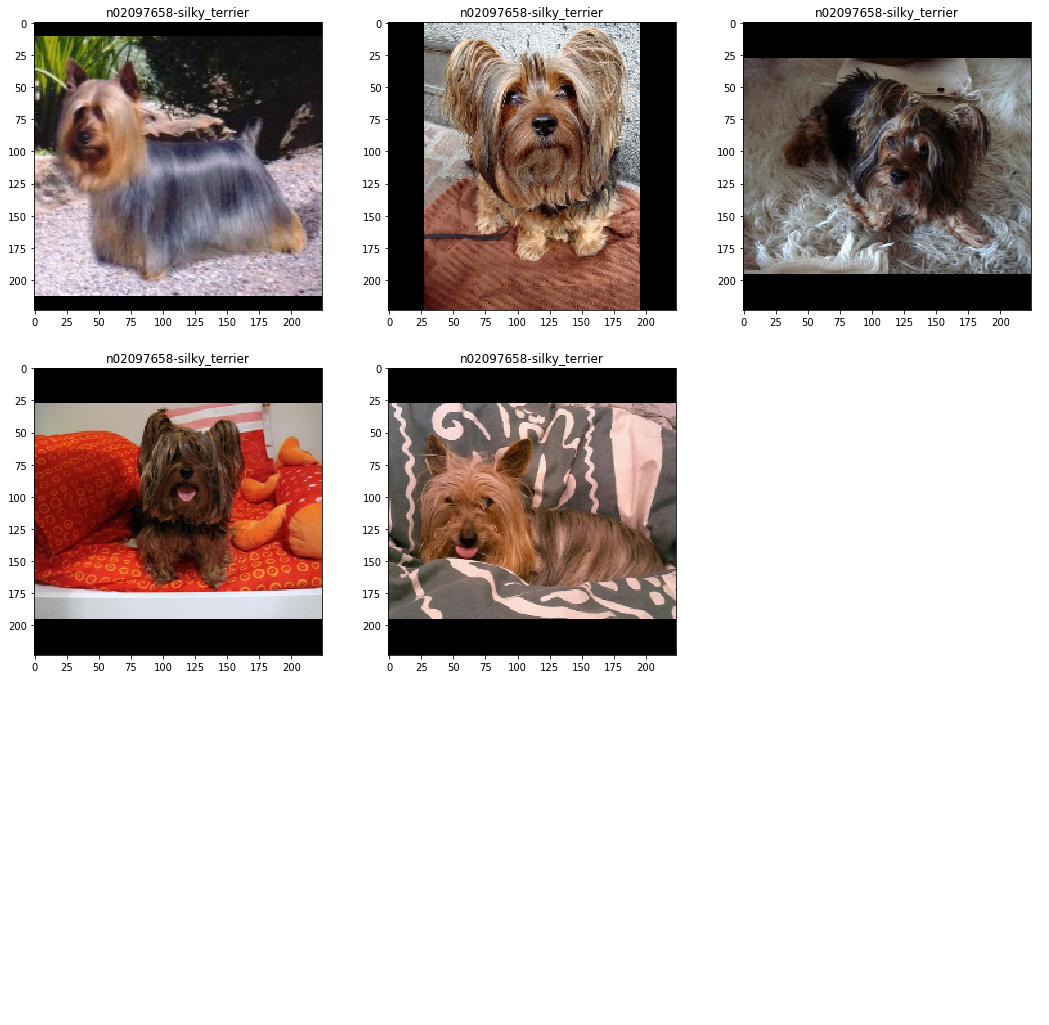

In [4]:
# slicing으로도 가능하고
image, label = dex[10:15]
plot_images(image, label)

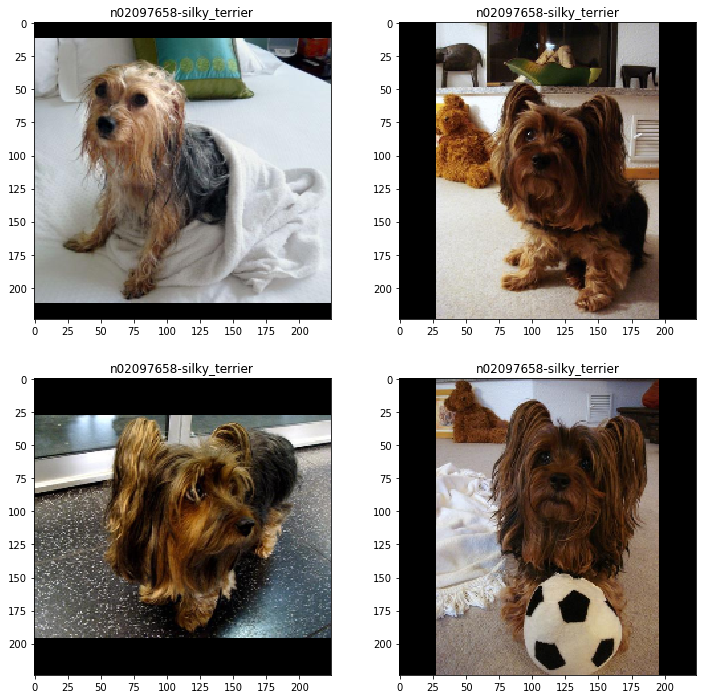

In [5]:
# list로도 가능합니다.
image, label = dex[[0,5,9, 8]]
plot_images(image, label)

-----

## 2. transform.py

`transform.py`는 기본적으로 `scikit-learn`에서 제공하는 `pipeline`과 `Transformer`의 형태로 구현되었습니다. 이는 imgaug와 같이 chainer형태로 코드를 구성할 수 있으며, 단일한 형태로도 동작가능하도록 구현되었습니다.

호출 방식은 아래와 같습니다

In [6]:
# Image Preprocessing

## 0.5확률로 좌우 반전
randomflip = RandomFlip() 
## random하게 rescale 후 원래 이미지 사이즈만큼 crop
randomrescale = RandomRescaleAndCrop(max_ratio=1.3) 
## random하게 이미지를 돌림
randomrotation = RandomRotation(max_degree=30)
## Randomg하게 RGB별로 값을 shift함
randomshift = RandomColorShift(max_shift=20)

normalization = Normalization() # 0~255 -> 0~1로 정규화

아래와 같이 1개의 이미지에 적용할 수 있고

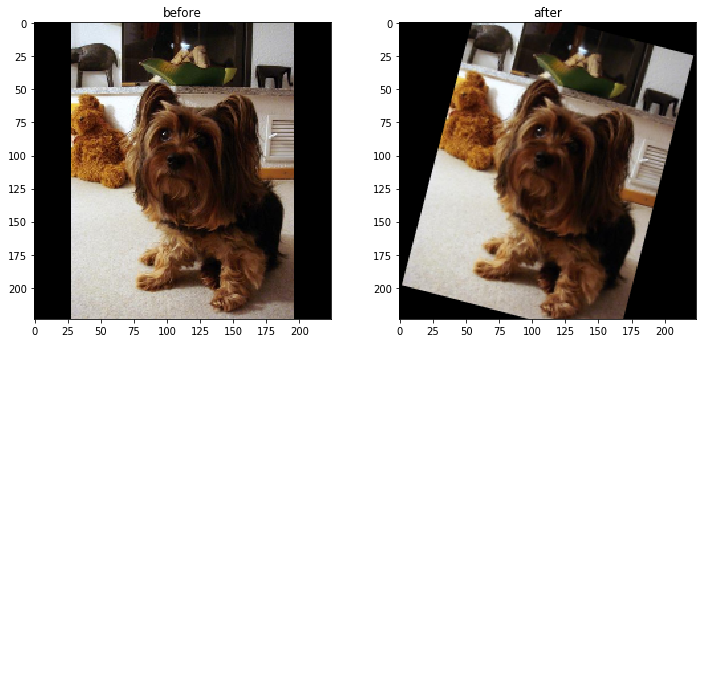

In [7]:
image, label = dex[5]
after = randomrotation(image)
plot_images([image, after], ['before','after'])

복수개의 이미지에 적용할 수 있습니다

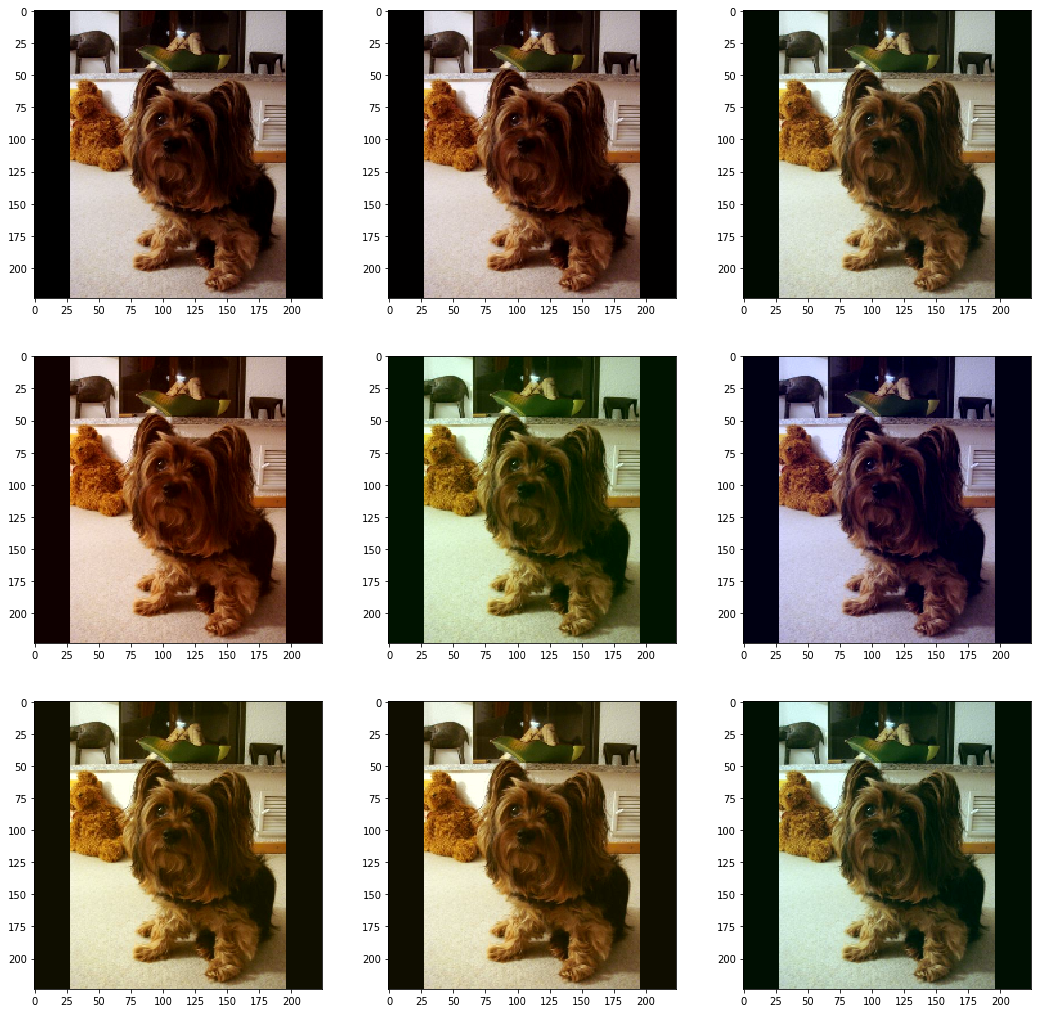

In [8]:
repeat = 9
images = [image for _ in range(repeat)]
plot_images(randomshift(images))

파이프라인을 이용하면, chainer의 형태로 순차적으로 preprocessing을 적용할 수 있습니다

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


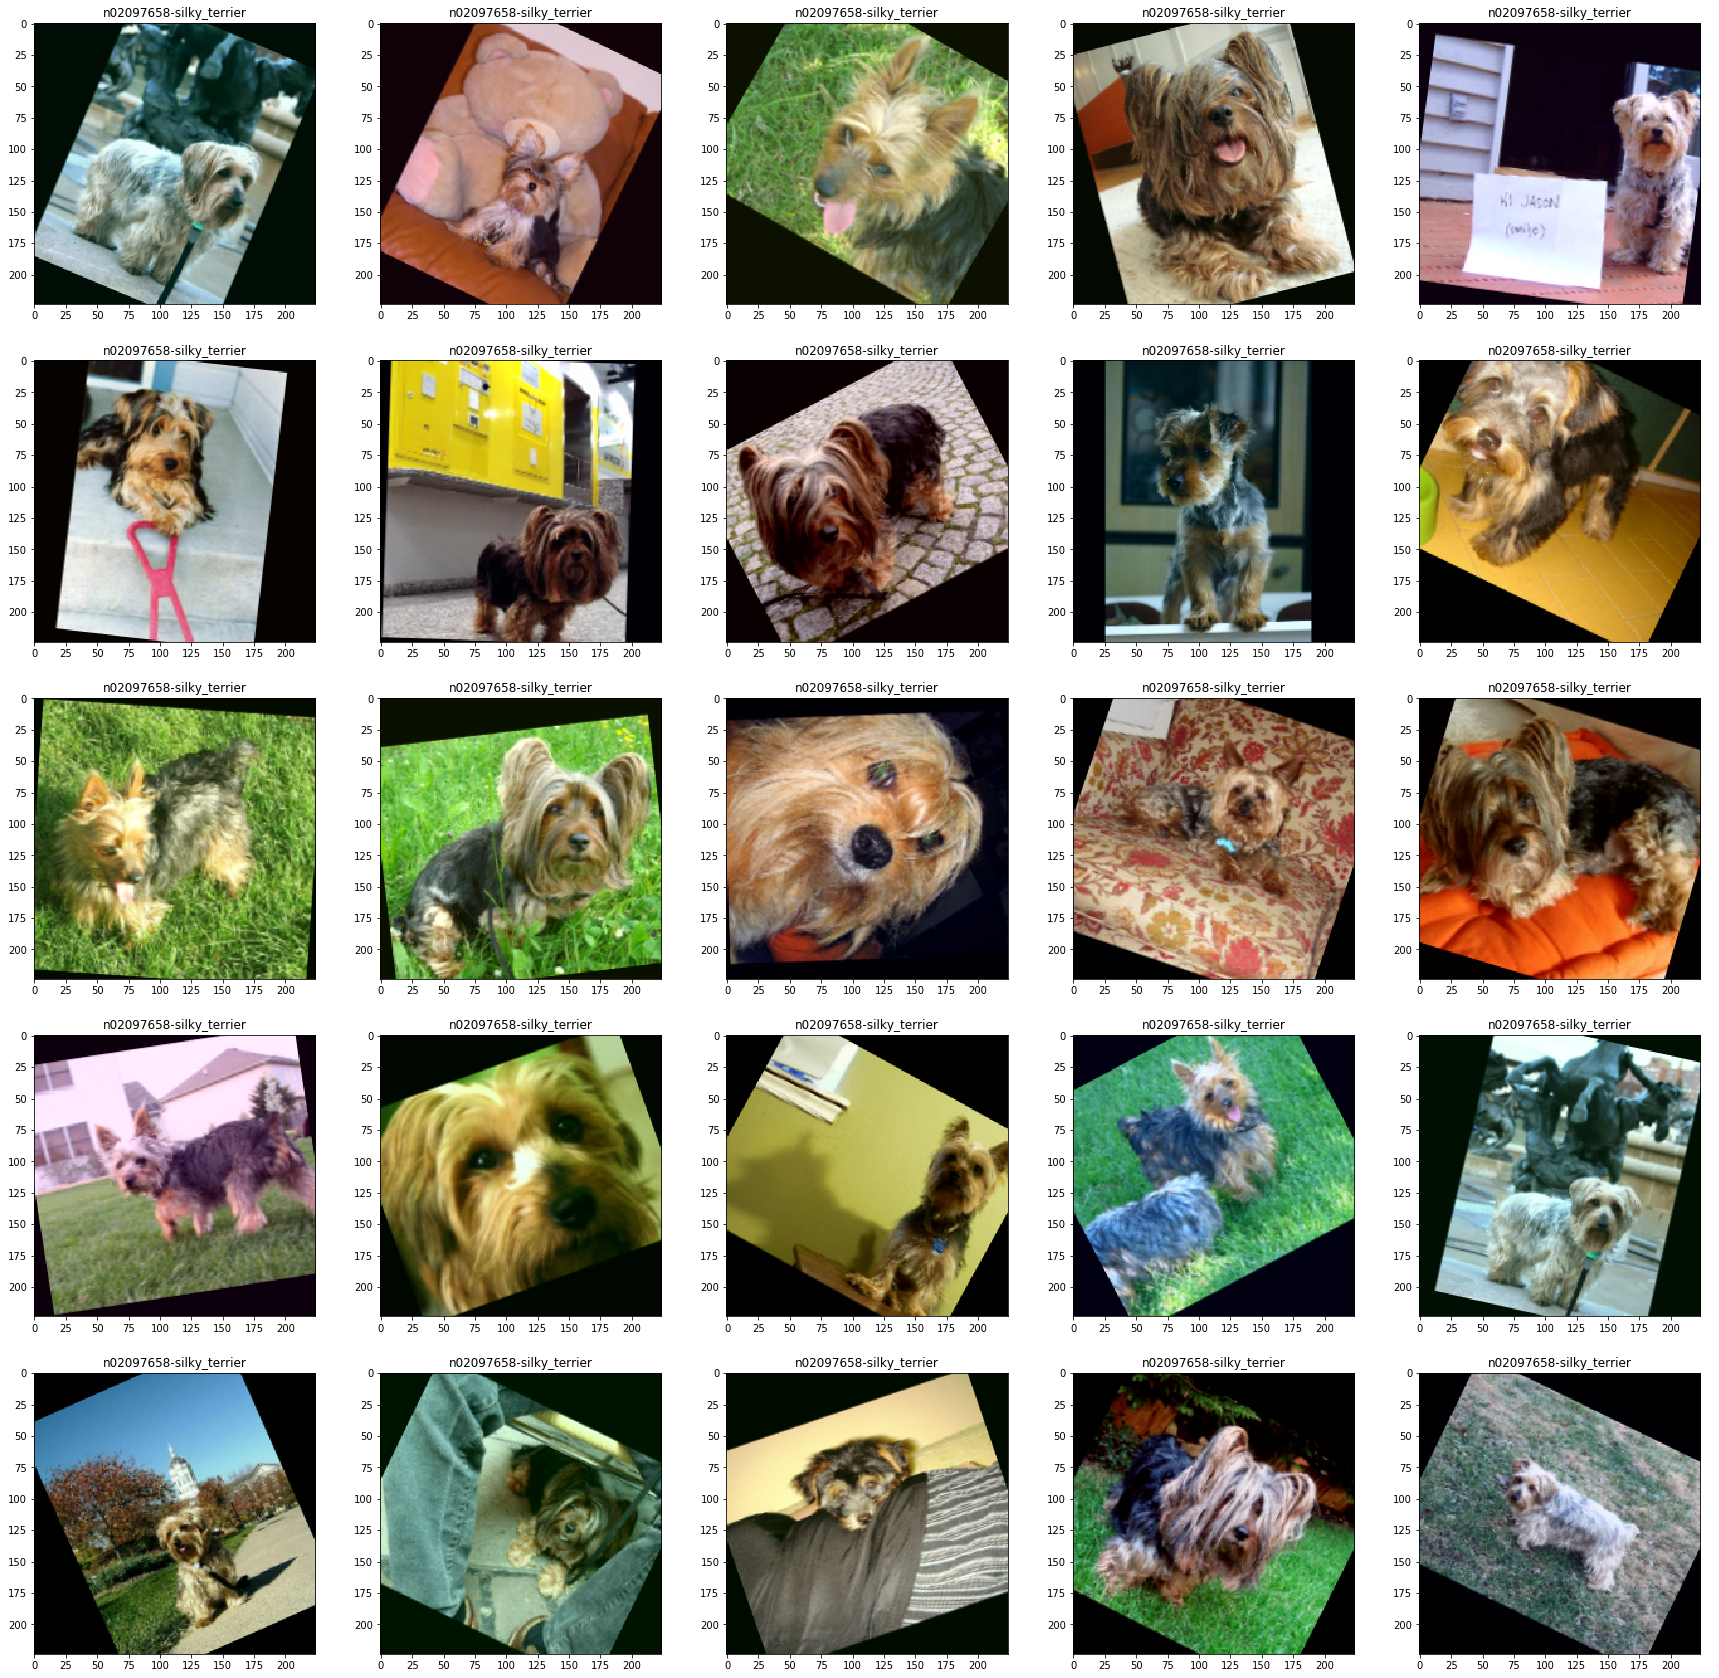

In [9]:
train_pipeline = Pipeline([
    ("랜덤으로 좌우 반전", randomflip),
    ("랜덤으로 rescale 후 crop", randomrescale),
    ("랜덤으로 rotation", randomrotation),
    ("랜덤으로 RGB color의 값을 shift", randomshift),
    ('0~1 범위로 정규화', normalization)
])

images, labels = dex[20:45]
images = train_pipeline.transform(images)
plot_images(images, labels)

### 3. load.py

`load.py`는 keras의 data generator 형태로 구현되었습니다. `extract.py`와 `transform.py`의 코드들을 함께 적용하여 구현하였습니다.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
# 데이터셋 내의 라벨의 비율을 유지하며 split하는 방식
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
train_index, test_index = next(split.split(dex.index, dex.labels))

In [12]:
train_value_counts = dex.labels[train_index].value_counts() / len(dex.labels[train_index]) * 100
test_value_counts = dex.labels[test_index].value_counts() / len(dex.labels[test_index]) * 100

train 내의 라벨의 비율과 test 내의 라벨의 비율을 아래와 같이 비슷하게 유지시켜 준다.

In [13]:
train_value_counts[:10]

n02085936-Maltese_dog             1.221713
n02088094-Afghan_hound            1.159239
n02092002-Scottish_deerhound      1.124531
n02112018-Pomeranian              1.062057
n02107683-Bernese_mountain_dog    1.062057
n02111889-Samoyed                 1.062057
n02090721-Irish_wolfhound         1.062057
n02086240-Shih-Tzu                1.041233
n02111500-Great_Pyrenees          1.034291
n02111129-Leonberg                1.020408
Name: label, dtype: float64

In [14]:
test_value_counts[:10]

n02085936-Maltese_dog             1.230969
n02088094-Afghan_hound            1.166181
n02092002-Scottish_deerhound      1.133787
n02112018-Pomeranian              1.068999
n02107683-Bernese_mountain_dog    1.052802
n02090721-Irish_wolfhound         1.052802
n02111889-Samoyed                 1.052802
n02111500-Great_Pyrenees          1.036605
n02086240-Shih-Tzu                1.036605
n02110806-basenji                 1.020408
Name: label, dtype: float64

In [15]:
gen = DogDataGenerator(dex, train_index, train_pipeline, batch_size=16)

In [16]:
batch_images, batch_labels = gen[0]

In [17]:
batch_images.shape

(16, 224, 224, 3)

In [18]:
batch_labels.shape

(16, 120)